# Normalizing flows
Deconvolving 3 Perpendicular Gaussians with MAFs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_gaussians(data, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):
    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

## Deconvolution

#===================================================================================================
INFO: created directory: ../../results/smeared_gaussians.DeconvolutionFlow.MAF_RQS.2024.01.30_18h42
#===================================================================================================
+---------------------+--------------------+
| Parameters          | Values             |
+---------------------+--------------------+
| DATA                | smeared_gaussians  |
| features            | ['x', 'y']         |
| num_points          | 37500              |
| dim_input           | 2                  |
| noise_cov           | [[0.1, 0], [0, 1]] |
| preprocess          | []                 |
| cuts                | x: [-inf, inf]     |
|                     | y: [-inf, inf]     |
| DEVICE              | cpu                |
| optimizer           | Adam               |
| lr                  | 0.0001             |
| weight_decay        | 1e-05              |
| optimizer_betas     |

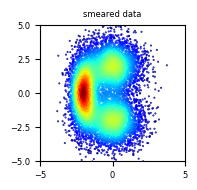

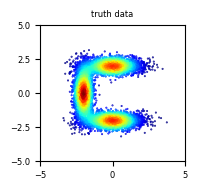

In [2]:
from deconvolution.trainer.trainer import Trainer
from deconvolution.configs.deconvolution_configs import Deconvolution_Gauss_MAF_RQS_NormFlow as Configs

configs = Configs(DATA = 'smeared_gaussians',
                num_points = 37500,
                data_split_fracs = [0.8, 0.2, 0.0],
                noise_cov = [[0.1, 0],[0, 1]],
                num_transforms = 5,
                dim_hidden = 16, 
                num_mc_draws = 50,
                num_blocks = 2,
                tail_bound = 10,
                num_bins = 10,
                batch_size = 512,
                EPOCHS = 100,
                early_stopping = None,
                min_epochs = None,
                print_epochs = 2,
                lr = 1e-4,
                weight_decay = 1e-5,
                num_workers = 8,
                pin_memory = True,
                DEVICE = 'cpu'
               )

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

from deconvolution.datamodules.toys.datasets import SmearedGaussDataset
from deconvolution.datamodules.toys.dataloader import ToysDataLoader 

gaussians = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(gaussians, configs)

plot_gaussians(gaussians.smeared, title='smeared data', num_points=10000)
plot_gaussians(gaussians.truth, title='truth data', num_points=10000)


In [3]:
from deconvolution.models.nflow_nets import MAFPiecewiseRQS
from deconvolution.dynamics.nf.normflows import DeconvolutionFlow

flow = Trainer(dynamics = DeconvolutionFlow(configs), 
               model = MAFPiecewiseRQS(configs), 
               dataloader = dataloader, 
               configs = configs)

flow.train()

number of training parameters: 9468
start training...


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 5.462193044565491, valid loss: 5.019714959462484  (min valid loss: 5.019714959462484)
	Epoch: 3, train loss: 4.242471403994803, valid loss: 4.1099402109781895  (min valid loss: 4.1099402109781895)
	Epoch: 5, train loss: 3.90750126919504, valid loss: 3.853744204839071  (min valid loss: 3.853744204839071)
	Epoch: 7, train loss: 3.7671736862699863, valid loss: 3.740652434031169  (min valid loss: 3.740652434031169)
	Epoch: 9, train loss: 3.7074135319661288, valid loss: 3.69532486597697  (min valid loss: 3.69532486597697)
	Epoch: 11, train loss: 3.6832738084308168, valid loss: 3.673734140396118  (min valid loss: 3.673734140396118)
	Epoch: 13, train loss: 3.6697881827920167, valid loss: 3.6597103913625078  (min valid loss: 3.6597103913625078)
	Epoch: 15, train loss: 3.6601779662956626, valid loss: 3.6530931631724033  (min valid loss: 3.6530931631724033)
	Epoch: 17, train loss: 3.6544171309067033, valid loss: 3.641931772232055  (min valid loss: 3.641931772232055)
	Epoch

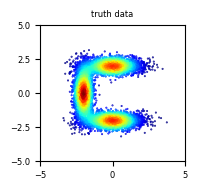

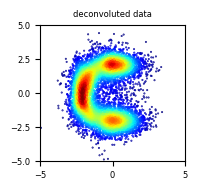

In [4]:
from deconvolution.pipelines.SamplingPipeline import NormFlowPipeline 

pipeline = NormFlowPipeline(trained_model=flow, best_epoch_model=True)
pipeline.generate_samples(num=10000)

plot_gaussians(gaussians.truth, title='truth data', num_points=10000)
plot_gaussians(pipeline.target, title='deconvoluted data')